## Neural networks for segmentation

In [1]:
#! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
#! unzip -q data.zip

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [3]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/waytobehigh/ds/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


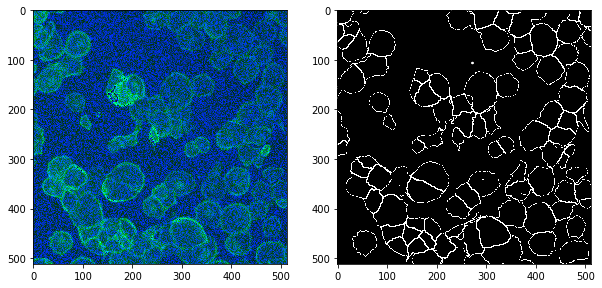

In [4]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [5]:
import torch
import torchvision

import torch.nn as nn
import torchvision.transforms as T

from torchvision.datasets import DatasetFolder
from torch.utils.data.dataloader import DataLoader

So I decided to reimplement IOU function in order to improve the perfomance.

In [6]:
def calc_iou(ground_truth, prediction):
    intersection = np.logical_and(prediction, ground_truth).astype(np.float32).sum() 
    union = np.logical_or(prediction, ground_truth).astype(np.float32).sum()
    return intersection / union

Let's implement basic UNet [from here](https://arxiv.org/pdf/1505.04597.pdf) and try to prevent expected overfitting by adding some dropout to the end of each block.

In [7]:
class Block(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

        
class Down(nn.Sequential):
    def __init__(self, in_ch, out_ch):
        super().__init__(
            nn.MaxPool2d(2),
            Block(in_ch, out_ch)
        )
        
        
class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)
        self.block = Block(in_ch, out_ch)

        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        dH = x2.size()[2] - x1.size()[2]
        dW = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(x1, (dW // 2, dW // 2, dH // 2, dH // 2))

        x = torch.cat([x2, x1], dim=1)
        x = self.block(x)
        
        return x

In [8]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inconv = Block(n_channels, 64)
        
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        
        self.outconv = nn.Conv2d(64, n_classes, 1)

        
    def forward(self, x):
        x1 = self.inconv(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        x = self.outconv(x)
        
        return x

In [9]:
model = UNet()

Now is the time to create an alternative to ImageFolder from torchvision that could read and match masks and images from two separate directories.

In [29]:
import os
from PIL import Image


class SegmentationSplittedDataset():
    def __init__(self, images_path, masks_path=None, extentions=None, transform=None, key=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.extentions = extentions or ['']
        self.transform = transform
        self.key = key
        
        self._to_tensor = T.ToTensor()
        
        self._images = self._collect_samples(images_path)
        
        if masks_path:
            self._masks = self._collect_samples(masks_path)
        
        
    def __getitem__(self, i):
        image = self._load_image(self._images[i])
        
        if self.masks_path:
            mask = self._load_image(self._masks[i], grayscale=True)
        
        
        if self.transform:
            if self.masks_path:
                tmp = self.transform(image=image, mask=mask)
                image, mask = tmp['image'], tmp['mask']
                image, mask = self._to_tensor(image), self._to_tensor(mask)
                mask = (mask > 0).type(torch.float32)
            else:
                image = self.transform(image=image)
                image = self._to_tensor(image)
        else:
            if self.masks_path:
                image, mask = self._to_tensor(image), self._to_tensor(mask)
            else:
                image = self._to_tensor(image)
        
        return (image, mask) if self.masks_path else image
    
    
    def __len__(self):
        return len(self._images)
    
    
    def _has_allowed_extension(self, file_names):
        return sum(True for extention in self.extentions if file_names.endswith(extention))
        
        
    def _collect_samples(self, path):
        path = os.path.expanduser(path)
        root, _, file_names = next(iter(os.walk(path)))
                
        return [os.path.join(root, file_name) for file_name in sorted(file_names, key=self.key)
                if self._has_allowed_extension(file_name)]
    
    
    def _load_image(self, path, grayscale=False):
        with open(path, 'rb') as file:
            image = Image.open(file)
            image = image.convert('L') if grayscale else image.convert('RGB')
            return np.array(image)

For data augmentation we'll use one of the most trusted libraries on Kaggle $-$ albumentations.

In [11]:
import albumentations as aug

In [12]:
transform = aug.Compose([
    aug.Flip(),
    aug.RandomBrightnessContrast(),
    aug.ShiftScaleRotate(),
])

train_dataset = SegmentationSplittedDataset('BBBC018_v1_images-fixed/train/',
                                            'BBBC018_v1_outlines/train/',
                                            transform=transform)
val_dataset = SegmentationSplittedDataset('BBBC018_v1_images-fixed/val/',
                                          'BBBC018_v1_outlines/val/')

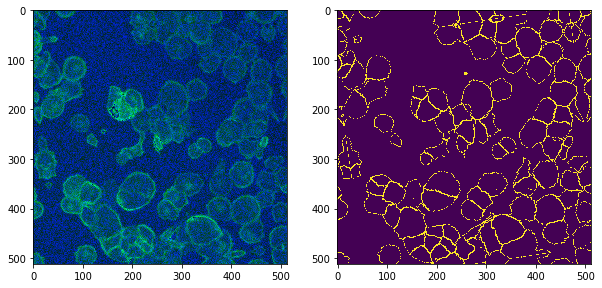

In [13]:
im, mask = train_dataset[0]
plt.figure(figsize=(10, 7))
plt.subplot('121').imshow(im.permute(1, 2, 0))
plt.subplot('122').imshow(mask.reshape(512, 512));

In [14]:
train_batch_gen = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_batch_gen = DataLoader(val_dataset, batch_size=2, shuffle=True)

One of the experiments performed included usage of jacard_loss (implementation drawn [from here](https://github.com/kevinzakka/pytorch-goodies/)), which did not improve the result.

In [15]:
def jaccard_loss(true, logits, eps=1e-7):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the jaccard loss so we
    return the negated jaccard loss.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        jacc_loss: the Jaccard loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    union = cardinality - intersection
    jacc_loss = (intersection / (union + eps)).mean()
    return (1 - jacc_loss)

Finally, we'll take the structure of model fitting from HW2 and redefine loss computation specifically for this task.

In [16]:
import numpy as np
from IPython.display import clear_output
from collections import namedtuple

Logger = namedtuple('Logger', ['train_loss_', 'train_score_', 'val_loss_', 'val_score_'])
TRESHOLD = 0.2


def compute_loss(model, X_batch, y_batch, C=0, criterion=nn.L1Loss(size_average=False)):
    logits = model.cuda()(X_batch.cuda())
    
    #loss = jaccard_loss(y_batch.cuda().type(torch.int64), logits)
    loss = nn.functional.binary_cross_entropy_with_logits(logits, y_batch.cuda())
    
    if C:
        reg_loss = 0
        for param in model.parameters():
            reg_loss += criterion(param, torch.zeros(param.shape).cuda())
        
        loss += C * reg_loss
    
    return logits, loss


def get_logger():
    return Logger(*[[] for _ in range(4)])


def evaluate_model(model, val_batch_gen, metric_func, C=0, logs=None, treshold=TRESHOLD):
    if not logs:
        logs = get_logger()
    
    model.train(False)
    for X_batch, y_batch in val_batch_gen:
        logits, loss = compute_loss(model, X_batch, y_batch, C)
        y_pred = nn.functional.sigmoid(logits)
        logs.val_loss_.append(loss.cpu().data.numpy())
        logs.val_score_.append(metric_func(y_batch.numpy(), (y_pred > treshold).cpu().numpy()))
        
    return logs


def train_model(model, train_batch_gen, val_batch_gen, metric_func, n_epochs=50,
                plot_graph=True, C=0, **optimizer_params):
    opt = torch.optim.Adam(model.parameters(), **optimizer_params)
    logs = get_logger()
    
    for epoch in range(n_epochs):
        epoch_logs = get_logger()
        
        model.train(True)
        for X_batch, y_batch in train_batch_gen:
            logits, loss = compute_loss(model, X_batch, y_batch, C)
            y_pred = nn.functional.sigmoid(logits)
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_logs.train_loss_.append(loss.cpu().data.numpy())
            epoch_logs.train_score_.append(metric_func(y_batch.numpy(), (y_pred > TRESHOLD).cpu().numpy()))
        
        evaluate_model(model, val_batch_gen, metric_func, C, epoch_logs)
            
        for attr in dir(epoch_logs):
            if attr.endswith('_') and not attr.endswith('__'):
                getattr(logs, attr).append(np.mean(getattr(epoch_logs, attr)))
    
        if plot_graph:
            clear_output()
            plt.figure(figsize=(15, 5))
            grid = np.arange(1, epoch + 2)
            
            fig = plt.subplot(121)
            fig.set_title('Loss in dependency on number of epochs')
            fig.plot(grid, logs.train_loss_, label='train')
            fig.plot(grid, logs.val_loss_, label='val')
            fig.set_xlabel('epoch')
            fig.set_ylabel('loss')
            fig.legend()
            fig.grid()
            
            fig = plt.subplot(122)
            fig.set_title('Score in dependency on number of epochs')
            fig.plot(grid, logs.train_score_, label='train')
            fig.plot(grid, logs.val_score_, label='val')
            fig.set_xlabel('epoch')
            fig.set_ylabel('Score')
            fig.legend()
            fig.grid()
            
            plt.show()
            
    return logs

/home/waytobehigh/ds/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


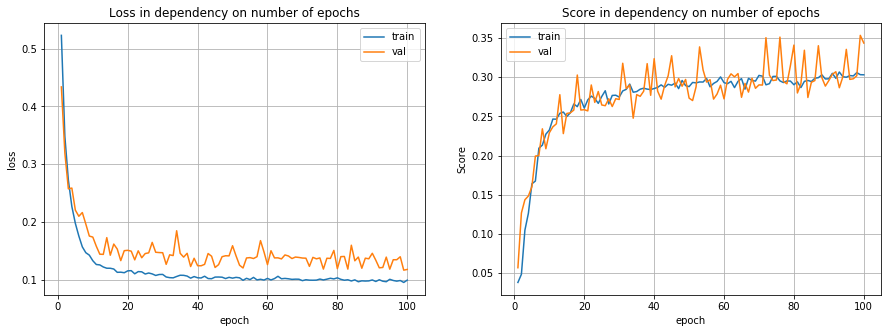

In [17]:
logs = train_model(model, train_batch_gen, val_batch_gen, calc_iou, C=10e-7, n_epochs=100)

As we are segmenting only edges of cells, it implies that we are dealing with imbalanced classes (approximately each sample contains less than 10% of 1). Therefore it makes sense that our model is afraid of predicting high probabilities for the first class, that's why we need some treshold magic :)

In [18]:
logs = get_logger()
grid = np.linspace(0.15, 0.5, 50)

for treshold in grid:
    epoch_logs = get_logger()
    evaluate_model(model, val_batch_gen, calc_iou, 10e-7, epoch_logs, treshold)
    
    for attr in dir(epoch_logs):
        if attr.endswith('_') and not attr.endswith('__'):
            getattr(logs, attr).append(np.mean(getattr(epoch_logs, attr)))

/home/waytobehigh/ds/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/waytobehigh/ds/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


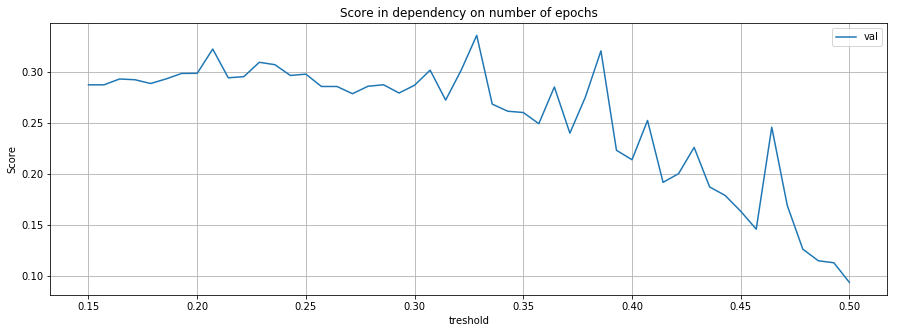

In [19]:
plt.figure(figsize=(15, 5))

fig = plt.subplot(111)
fig.set_title('Score in dependency on number of epochs')
fig.plot(grid, logs.val_score_, label='val')
fig.set_xlabel('treshold')
fig.set_ylabel('Score')
fig.legend()
fig.grid()

plt.show()

Somehow I initially set one of the best treshold (0.2) for metric evaluation... Now let's predict test set and save our predictions into a file.

In [30]:
test_dataset = SegmentationSplittedDataset('BBBC018_v1_images-fixed/test/')

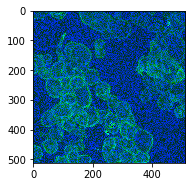

In [31]:
plt.subplot('121').imshow(test_dataset[0].permute(1, 2, 0))

In [32]:
len(test_loader)

7

In [88]:
def predict_test(model, test_dataset, treshold):
    predictions = []
    for sample, path in zip(test_dataset, test_dataset._images):
        logits = model.cuda()(sample.cuda().reshape(1, *sample.shape))
        preds = nn.functional.sigmoid(logits) > treshold
        predictions.append((np.squeeze(preds.cpu().numpy()), path.replace('test', 'predicted_test')))
        
    return predictions


def save_predictions(predictions):
    for sample, path in predictions:
        print('Saving', path)
        im = Image.fromarray(sample * 255)
        im.save(path)

In [89]:
predictions = predict_test(model, test_dataset, 0.205)

/home/waytobehigh/ds/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [90]:
save_predictions(predictions)

Saving BBBC018_v1_images-fixed/predicted_test/00733-actin.DIB.bmp
Saving BBBC018_v1_images-fixed/predicted_test/05624-actin.DIB.bmp
Saving BBBC018_v1_images-fixed/predicted_test/05899-actin.DIB.bmp
Saving BBBC018_v1_images-fixed/predicted_test/10780-actin.DIB.bmp
Saving BBBC018_v1_images-fixed/predicted_test/13361-actin.DIB.bmp
Saving BBBC018_v1_images-fixed/predicted_test/13569-actin.DIB.bmp
Saving BBBC018_v1_images-fixed/predicted_test/19466-actin.DIB.bmp


That's all! Some improvement's I would have done if I had <strike>had any bonuses :)</strike> spent more time:
* class weights
* augmentation analysis (how crop size, angle of rotation and brightness/contrast affect the score)
* edge-sensetive loss (punishing model for non-continious predictions, saw an article on this topic)